In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Pancreatic_Adenocarcinoma_dataset.zip

In [ ]:
!apt-get install openslide-tools
!pip install openslide-python
!pip install opencv-python

In [ ]:
!pip install tensorflow==2.3.1

In [1]:
import json
 
# Opening JSON file
f = open('/content/drive/MyDrive/PDA.json',)
 
# returns JSON object as
# a dictionary
data = json.load(f)

import os
pancreatic_ductal_adenocarcinoma_SVS_FILES_path = os.listdir("/content/drive/MyDrive/Pancreatic_Ductal_Adenocarcinoma")

In [3]:
pancreatic_ductal_adenocarcinoma_SVS_FILES_path

['C3L-00017-21.svs',
 'C3L-00017-22.svs',
 'C3L-00017-23.svs',
 'C3L-00017-24.svs',
 'C3L-00017-25.svs',
 'C3L-00017-26.svs',
 'C3L-00102-21.svs',
 'C3L-00102-22.svs',
 'C3L-00102-26.svs',
 'C3L-00189-21.svs',
 'C3L-00189-22.svs',
 'C3L-00189-23.svs',
 'C3L-00189-24.svs',
 'C3L-00277-21.svs',
 'C3L-00277-22.svs',
 'C3L-00277-23.svs',
 'C3L-00277-24.svs',
 'C3L-00277-25.svs',
 'C3L-00277-26.svs',
 'C3L-00395-21.svs',
 'C3L-00395-22.svs',
 'C3L-00395-24.svs',
 'C3L-00395-23.svs',
 'C3L-00401-22.svs',
 'C3L-00401-24.svs',
 'C3L-00401-25.svs',
 'C3L-00401-28.svs',
 'C3L-00589-21.svs',
 'C3L-00589-22.svs',
 'C3L-00589-26.svs',
 'C3L-00598-21.svs',
 'C3L-00598-22.svs',
 'C3L-00598-23.svs',
 'C3L-00598-24.svs',
 'C3L-00599-21.svs',
 'C3L-00599-22.svs',
 'C3L-00599-23.svs',
 'C3L-00599-24.svs']

In [4]:
import tensorflow as tf


import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
from skimage.color import rgb2gray
import cv2
import os
import random
import pathlib
import openslide
import PIL
from PIL import Image
from openslide.lowlevel import *
from openslide.lowlevel import _convert

In [5]:
def load_image(slide_path):

    # Loading the slide image and the tumor mask image
    slide = open_slide(slide_path)
   

    
   
    print(slide.level_dimensions)
    print("---",slide.level_downsamples[2],slide.level_dimensions[2][0])
    # Verify downsampling works as expected
    width, height = slide.level_dimensions[2]
    print(width,height)
    #assert width * slide.level_downsamples[2] == slide.level_dimensions[2][0]
    #assert height * slide.level_downsamples[2] == slide.level_dimensions[0][1]

    return slide  

def read_slide(slide, x, y, level, width, height, as_float=False):

    # Reading the slides and converting them into a RGB numpy array
    openslide.lowlevel._load_image = _load_image_morethan_2_29
    im = slide.read_region((x, y), level, (width, height))
    im = im.convert('RGB')  # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im  


def _load_image_lessthan_2_29(buf, size):
    '''buf must be a mutable buffer.'''
    _convert.argb2rgba(buf)
    return PIL.Image.frombuffer('RGBA', size, buf, 'raw', 'RGBA', 0, 1)


def _load_image_morethan_2_29(buf, size):
    '''buf must be a buffer.'''

    # Load entire buffer at once if possible
    MAX_PIXELS_PER_LOAD = (1 << 29) - 1
    # Otherwise, use chunks smaller than the maximum to reduce memory
    # requirements
    PIXELS_PER_LOAD = 1 << 26

    def do_load(buf, size):
        '''buf can be a string, but should be a ctypes buffer to avoid an
        extra copy in the caller.'''
        # First reorder the bytes in a pixel from native-endian aRGB to
        # big-endian RGBa to work around limitations in RGBa loader
        rawmode = (sys.byteorder == 'little') and 'BGRA' or 'ARGB'
        buf = PIL.Image.frombuffer('RGBA', size, buf, 'raw', rawmode, 0, 1)
        # Image.tobytes() is named tostring() in Pillow 1.x and PIL
        buf = (getattr(buf, 'tobytes', None) or buf.tostring)()
        # Now load the image as RGBA, undoing premultiplication
        return PIL.Image.frombuffer('RGBA', size, buf, 'raw', 'RGBa', 0, 1)

    # Fast path for small buffers
    w, h = size
    if w * h <= MAX_PIXELS_PER_LOAD:
        return do_load(buf, size)

    # Load in chunks to avoid OverflowError in PIL.Image.frombuffer()
    # https://github.com/python-pillow/Pillow/issues/1475
    if w > PIXELS_PER_LOAD:
        # We could support this, but it seems like overkill
        raise ValueError('Width %d is too large (maximum %d)' %
                         (w, PIXELS_PER_LOAD))
    rows_per_load = PIXELS_PER_LOAD // w
    img = PIL.Image.new('RGBA', (w, h))
    for y in range(0, h, rows_per_load):
        rows = min(h - y, rows_per_load)
        if sys.version[0] == '2':
            chunk = buffer(buf, 4 * y * w, 4 * rows * w)
        else:
            # PIL.Image.frombuffer() won't take a memoryview or
            # bytearray, so we can't avoid copying
            chunk = memoryview(buf)[y * w:(y + rows) * w].tobytes()
        img.paste(do_load(chunk, (w, rows)), (0, y))
    return img              

In [ ]:
slide  = load_image("/content/drive/MyDrive/Pancreatic_Ductal_Adenocarcinoma/"+pancreatic_ductal_adenocarcinoma_SVS_FILES_path[37])
width, height = slide.level_dimensions[1][0], slide.level_dimensions[1][1]
slide = read_slide(slide,
                       x=0,
                       y=0,
                       level=1,
                       width=width,
                       height=height)

import matplotlib.pyplot as plt
plt.figure(figsize=(50,20))
plt.imshow(slide)

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

import os
import numpy as np
%matplotlib inline

from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np


## Must be openslide version 3.4.1
from openslide import open_slide, __library_version__ as openslide_version
print(openslide_version)
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1"

3.4.1


In [2]:
import tensorflow as tf


import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
from skimage.color import rgb2gray
import cv2
import os
import random
import pathlib
import openslide
import PIL
from PIL import Image
from openslide.lowlevel import *
from openslide.lowlevel import _convert


def _load_image_lessthan_2_29(buf, size):
    '''buf must be a mutable buffer.'''
    _convert.argb2rgba(buf)
    return PIL.Image.frombuffer('RGBA', size, buf, 'raw', 'RGBA', 0, 1)


def _load_image_morethan_2_29(buf, size):
    '''buf must be a buffer.'''

    # Load entire buffer at once if possible
    MAX_PIXELS_PER_LOAD = (1 << 29) - 1
    # Otherwise, use chunks smaller than the maximum to reduce memory
    # requirements
    PIXELS_PER_LOAD = 1 << 26

    def do_load(buf, size):
        '''buf can be a string, but should be a ctypes buffer to avoid an
        extra copy in the caller.'''
        # First reorder the bytes in a pixel from native-endian aRGB to
        # big-endian RGBa to work around limitations in RGBa loader
        rawmode = (sys.byteorder == 'little') and 'BGRA' or 'ARGB'
        buf = PIL.Image.frombuffer('RGBA', size, buf, 'raw', rawmode, 0, 1)
        # Image.tobytes() is named tostring() in Pillow 1.x and PIL
        buf = (getattr(buf, 'tobytes', None) or buf.tostring)()
        # Now load the image as RGBA, undoing premultiplication
        return PIL.Image.frombuffer('RGBA', size, buf, 'raw', 'RGBa', 0, 1)

    # Fast path for small buffers
    w, h = size
    if w * h <= MAX_PIXELS_PER_LOAD:
        return do_load(buf, size)

    # Load in chunks to avoid OverflowError in PIL.Image.frombuffer()
    # https://github.com/python-pillow/Pillow/issues/1475
    if w > PIXELS_PER_LOAD:
        # We could support this, but it seems like overkill
        raise ValueError('Width %d is too large (maximum %d)' %
                         (w, PIXELS_PER_LOAD))
    rows_per_load = PIXELS_PER_LOAD // w
    img = PIL.Image.new('RGBA', (w, h))
    for y in range(0, h, rows_per_load):
        rows = min(h - y, rows_per_load)
        if sys.version[0] == '2':
            chunk = buffer(buf, 4 * y * w, 4 * rows * w)
        else:
            # PIL.Image.frombuffer() won't take a memoryview or
            # bytearray, so we can't avoid copying
            chunk = memoryview(buf)[y * w:(y + rows) * w].tobytes()
        img.paste(do_load(chunk, (w, rows)), (0, y))
    return img


def read_slide(slide, x, y, level, width, height, as_float=False):

    # Reading the slides and converting them into a RGB numpy array
    openslide.lowlevel._load_image = _load_image_morethan_2_29
    im = slide.read_region((x, y), level, (width, height))
    im = im.convert('RGB')  # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im


def find_tissue_pixels(image, intensity=0.8):

    # Finding the pixels having value less than or equal to the intensity value
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])


def apply_mask(im, mask, color=1):

    # Applies the mask to the slides image
    masked = np.zeros((im.shape[0], im.shape[1]))
    for x, y in mask:
        masked[x][y] = color
    return masked


# This function makes the directories required during testing
def initialize_directories_test(slide_path, level):

    BASE_DIR = os.getcwd()

    img_num = slide_path[-16:-4]

    DATA = 'train_folder/'
    TRAIN="train/"
    IMG_NUM_FOLDER = img_num + '/'
    LEVEL_FOLDER = 'level_'+str(level)+'/'
    TISSUE_FOLDER = 'tissue_only/'
    ALL_FOLDER = 'all/'

    DATA_DIR = os.path.join(BASE_DIR, DATA)
    TRAIN_DIR = os.path.join(BASE_DIR, DATA,TRAIN)
    IMG_NUM_DIR = os.path.join(BASE_DIR, DATA,TRAIN, IMG_NUM_FOLDER)
    LEVEL_NUM_DIR = os.path.join(BASE_DIR, DATA,TRAIN, IMG_NUM_FOLDER, LEVEL_FOLDER)
    TISSUE_DIR = os.path.join(BASE_DIR, DATA,TRAIN, IMG_NUM_FOLDER, LEVEL_FOLDER, TISSUE_FOLDER)
    ALL_DIR = os.path.join(BASE_DIR, DATA,TRAIN, IMG_NUM_FOLDER, LEVEL_FOLDER, ALL_FOLDER)

    if not os.path.exists(DATA_DIR):
        os.mkdir(DATA_DIR)
    if not os.path.exists(TRAIN_DIR):
        os.mkdir(TRAIN_DIR)    
    if not os.path.exists(IMG_NUM_DIR):
        os.mkdir(IMG_NUM_DIR)
    if not os.path.exists(LEVEL_NUM_DIR):
        os.mkdir(LEVEL_NUM_DIR)
    if not os.path.exists(TISSUE_DIR):
        os.mkdir(TISSUE_DIR)
    if not os.path.exists(ALL_DIR):
        os.mkdir(ALL_DIR)

    return DATA + TRAIN + IMG_NUM_FOLDER + LEVEL_FOLDER + TISSUE_FOLDER, DATA + TRAIN + IMG_NUM_FOLDER + LEVEL_FOLDER + ALL_FOLDER


# This function is used to create the directories during training
def initialize_directories(slide_path, level):
    BASE_DIR = os.getcwd()

    img_num = slide_path.split('_')[1].strip(".svs")

    DATA = 'data/'
    IMG_NUM_FOLDER = img_num + '/'
    LEVEL_FOLDER = 'level_'+str(level)+'/'
    TUMOR_FOLDER = 'tumor/'
    NO_TUMOR_FOLDER = 'no_tumor/'

    DATA_DIR = os.path.join(BASE_DIR, DATA)
    IMG_NUM_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER)
    LEVEL_NUM_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, LEVEL_FOLDER)
    TUMOR_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, LEVEL_FOLDER, TUMOR_FOLDER)
    NO_TUMOR_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, LEVEL_FOLDER, NO_TUMOR_FOLDER)

    if not os.path.exists(DATA_DIR):
        os.mkdir(DATA_DIR)
    if not os.path.exists(IMG_NUM_DIR):
        os.mkdir(IMG_NUM_DIR)
    if not os.path.exists(LEVEL_NUM_DIR):
        os.mkdir(LEVEL_NUM_DIR)
    if not os.path.exists(TUMOR_DIR):
        os.mkdir(TUMOR_DIR)
    if not os.path.exists(NO_TUMOR_DIR):
        os.mkdir(NO_TUMOR_DIR)

    return DATA + IMG_NUM_FOLDER + LEVEL_FOLDER + TUMOR_FOLDER, DATA + IMG_NUM_FOLDER + LEVEL_FOLDER + NO_TUMOR_FOLDER


# Save the image as tissue or not
def split_image_test(im, tissue_mask, num_pixels, level_num, slide_path):
    x, y = im.shape[0], im.shape[1]
    x_count, y_count = int(np.ceil(x / num_pixels)), int(np.ceil(y / num_pixels))

    tissue_folder, all_folder = initialize_directories_test(slide_path, level_num)

    try:
        for i in range(x_count):
            for j in range(y_count):
                im_slice = np.zeros((num_pixels, num_pixels, 3))
                im_tissue_slice = np.zeros((num_pixels, num_pixels, 3))
                tissue_mask_slice = np.zeros((num_pixels, num_pixels))

                string_name = 'img_' + str(i * y_count + j)

                # Logic to handle the edges of the images
                if i == x_count - 1:
                    ub_x = x
                    assign_x = x - (x_count - 1) * num_pixels
                else:
                    ub_x = (i + 1) * num_pixels
                    assign_x = num_pixels

                if j == y_count - 1:
                    ub_y = y
                    assign_y = y - (y_count - 1) * num_pixels
                else:
                    ub_y = (j + 1) * num_pixels
                    assign_y = num_pixels

                tissue_mask_slice[0:assign_x, 0:assign_y] = tissue_mask[(i * num_pixels):ub_x, (j * num_pixels):ub_y]

                try:
                    if np.mean(tissue_mask_slice) > 0.7:
                        im_tissue_slice[0:assign_x, 0:assign_y, :] = im[(i * num_pixels):ub_x, (j * num_pixels):ub_y, :]
                        im_file_name_tissue = tissue_folder + string_name + ".jpg"
                        cv2.imwrite(im_file_name_tissue, im_tissue_slice)

                    im_slice[0:assign_x, 0:assign_y, :] = im[(i * num_pixels):ub_x, (j * num_pixels):ub_y, :]
                    im_file_name_all = all_folder + string_name + ".jpg"
                    cv2.imwrite(im_file_name_all, im_slice)

                except Exception as oerr:
                    print('Error with saving:', oerr)

    except Exception as oerr:
        print('Error with slicing:', oerr)



import tensorflow as tf


import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
from skimage.color import rgb2gray
import cv2
import os
import random
import pathlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import pandas as pd
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

# Load and preprocess image.
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

#Preprocess image
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image /= 255.0  # normalize to [0,1] range

    return image



def load_image(slide_path):

    # Loading the slide image and the tumor mask image
    slide = open_slide(slide_path)
  
    
    # Checking if the dimensions of the mask image and the slide image match or not
  
    print(slide.level_dimensions)
    print("---",slide.level_downsamples[2],slide.level_dimensions[2][0])
    # Verify downsampling works as expected
    width, height = slide.level_dimensions[2]
    print(width,height)
    #assert width * slide.level_downsamples[2] == slide.level_dimensions[2][0]
    #assert height * slide.level_downsamples[2] == slide.level_dimensions[0][1]

    return slide

In [3]:
def test_part_1(testing_image_path, num_pixels=64, num_level=2):

    slide_path_test = testing_image_path
  
    print(slide_path_test)

    # Retrieve slide parameters before overwriting
    slide = load_image(slide_path_test)
    width, height = slide.level_dimensions[num_level][0], slide.level_dimensions[num_level][1]

    # Read training image at slide level 3
    slide = read_slide(slide,
                       x=0,
                       y=0,
                       level=num_level,
                       width=width,
                       height=height)

    

    # Retrieve new array dimensions
    image_depth, image_width = int(np.ceil(slide.shape[0] / num_pixels)), int(np.ceil(slide.shape[1] / num_pixels))

    

    # Determine the portions of the image that are tissue
    tissue_pixels = list(find_tissue_pixels(slide))

    # Turn the tissue pixels into a mask
    tissue_regions = apply_mask(slide, tissue_pixels)

    split_image_test(slide, tissue_regions, num_pixels, num_level, slide_path_test)
    return image_depth, image_width, tissue_regions, slide

In [4]:
import pathlib
import random

def gen_image_paths_train(num_level=2):
    all_images_image_paths = []
    all_images_image_labels = []

    for i in range(1):

        slide_path = i

        #img_num = slide_path.split('_')[1].strip(".tiff")

        data_root_tumor = pathlib.Path('./Dataset/train_filter/level_' + str(num_level) + '/tumor')
        all_image_paths_tumor = list(data_root_tumor.glob('*'))
        num_tumor_images = len(all_image_paths_tumor)
        print("\nTotal number of tumor images",num_tumor_images)
        

        data_root_no_tumor = pathlib.Path('./Dataset/train_filter/level_' + str(num_level) + '/no_tumor')
        all_image_paths_no_tumor = list(data_root_no_tumor.glob('*'))
        num_no_tumor_images = len(all_image_paths_no_tumor)
        print("\nTotal number of normal images",num_no_tumor_images)
      

           
        all_image_paths = [str(path) for path in all_image_paths_tumor + all_image_paths_no_tumor ]
        random.shuffle(all_image_paths)

        data_root = pathlib.Path('./Dataset/train_filter/level_' + str(num_level))

        label_names = sorted(item.name for item in data_root.glob('*') if item.is_dir())

        label_to_index = dict((name, index) for index, name in enumerate(label_names))

        all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                            for path in all_image_paths]

        #update all image path lists
        all_images_image_paths = all_images_image_paths + all_image_paths
        all_images_image_labels = all_images_image_labels + all_image_labels

    return all_images_image_paths, all_images_image_labels

# Load and preprocess image.
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

#Preprocess image
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image /= 255.0  # normalize to [0,1] range

    return image    

def create_tf_dataset_train(all_image_paths_1, all_image_paths_2, all_image_paths_3, all_image_labels):

    path_ds_1 = tf.data.Dataset.from_tensor_slices(all_image_paths_1)
    image_ds_1 = path_ds_1.map(load_and_preprocess_image, num_parallel_calls=8)

    #path_ds_2 = tf.data.Dataset.from_tensor_slices(all_image_paths_2)
    #image_ds_2 = path_ds_2.map(load_and_preprocess_image, num_parallel_calls=8)

    #path_ds_3 = tf.data.Dataset.from_tensor_slices(all_image_paths_3)
    #image_ds3_3 = path_ds_3.map(load_and_preprocess_image, num_parallel_calls=8)

    label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

    image_label_ds = tf.data.Dataset.zip((image_ds_1, label_ds))

    BATCH_SIZE = 4

    steps_per_epoch = int(np.ceil(len(all_image_paths_1)/BATCH_SIZE))

    # Setting a shuffle buffer size larger than the dataset ensures that the data is completely shuffled.
    ds = image_label_ds.repeat()
    ds = ds.shuffle(buffer_size=4000)
    ds = ds.batch(BATCH_SIZE)
    # `prefetch` lets the dataset fetches batches, asynchronously while the model is training.
    ds = ds.prefetch(1)


    return ds, steps_per_epoch


def train_part(num_level_1=2, num_level_2=2, num_level_3=2):

    # change input here from a specific image to an image path
    all_image_paths_1, all_image_labels_1 = gen_image_paths_train(num_level_1)


    ## Create tf.Dataset for training
    ds, steps_per_epoch = create_tf_dataset_train(all_image_paths_1, all_image_paths_1, all_image_paths_1,all_image_labels_1)

    return ds, steps_per_epoch            

In [5]:
ds_train, steps_per_epoch_train = train_part()


Total number of tumor images 9652

Total number of normal images 9990


In [6]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers

import os
import numpy as np

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, GlobalAveragePooling2D, GlobalMaxPooling2D, Flatten, Concatenate, Conv2D, Input, Flatten, MaxPooling2D, UpSampling2D, concatenate, Cropping2D, Reshape, BatchNormalization

from tensorflow.keras.applications.nasnet import NASNetLarge
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.layers import Dense, concatenate
from tensorflow.keras.models import Model, load_model
%matplotlib inline


import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
import pandas as pd

In [7]:
def Dense_Net_121():
    
    inputs = Input((128, 128, 3))
    densenet121 = tf.keras.applications.DenseNet121(input_tensor=inputs, weights='imagenet', include_top=False)
    x = densenet121.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(16, activation='relu')(x)
    y = Dense(2, activation='softmax')(x)
    
    for layer in densenet121.layers:
        layer.trainable = False

    model = Model(inputs=inputs, outputs=y)

    return model

In [8]:
dense= Dense_Net_121()

In [54]:
with tf.device('/GPU:0'):
    print("TRUE")
    dense.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.sparse_categorical_crossentropy, 
              metrics = ['acc'])

    history_dense_121 =dense.fit(ds_train, epochs=50, steps_per_epoch=steps_per_epoch_train, verbose=1)

TRUE
Epoch 1/50
4911/4911 [==============================] - 146s 30ms/step - loss: 0.5713 - acc: 0.6787
Epoch 2/50
4911/4911 [==============================] - 145s 29ms/step - loss: 0.4960 - acc: 0.7383
Epoch 3/50
4911/4911 [==============================] - 144s 29ms/step - loss: 0.4682 - acc: 0.7574
Epoch 4/50
4911/4911 [==============================] - 144s 29ms/step - loss: 0.4509 - acc: 0.7707
Epoch 5/50
4911/4911 [==============================] - 145s 29ms/step - loss: 0.4373 - acc: 0.7825
Epoch 6/50
4911/4911 [==============================] - 145s 29ms/step - loss: 0.4238 - acc: 0.7828
Epoch 7/50
4911/4911 [==============================] - 144s 29ms/step - loss: 0.4147 - acc: 0.7949
Epoch 8/50
4911/4911 [==============================] - 144s 29ms/step - loss: 0.4055 - acc: 0.7991
Epoch 9/50
4911/4911 [==============================] - 144s 29ms/step - loss: 0.3973 - acc: 0.8032
Epoch 10/50
4911/4911 [==============================] - 144s 29ms/step - loss: 0.3895 - acc: 0

In [55]:
dense.save_weights("model.h5")

In [9]:
dense.load_weights("model.h5")

In [10]:
import tensorflow as tf


import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
from skimage.color import rgb2gray
import cv2
import os
import random
import pathlib
import openslide
import PIL
from PIL import Image
from openslide.lowlevel import *
from openslide.lowlevel import _convert


def test_part_1(testing_image_path, num_pixels=128, num_level=2):

    slide_path_test = testing_image_path

 

    # Retrieve slide parameters before overwriting
    slide  = load_image(slide_path_test)
    width, height = slide.level_dimensions[num_level][0], slide.level_dimensions[num_level][1]

    # Read training image at slide level 3
    slide = read_slide(slide,
                       x=0,
                       y=0,
                       level=num_level,
                       width=width,
                       height=height)

 

    # Retrieve new array dimensions
    image_depth, image_width = int(np.ceil(slide.shape[0] / num_pixels)), int(np.ceil(slide.shape[1] / num_pixels))

    
    # Determine the portions of the image that are tissue
    tissue_pixels = list(find_tissue_pixels(slide))

    # Turn the tissue pixels into a mask
    tissue_regions = apply_mask(slide, tissue_pixels)

    split_image_test(slide, tissue_regions, num_pixels, num_level, slide_path_test)
    return image_depth, image_width, tissue_regions, slide

def load_image(slide_path):

    # Loading the slide image and the tumor mask image
    slide = open_slide(slide_path)
   

    
   
    print(slide.level_dimensions)
    print("---",slide.level_downsamples[2],slide.level_dimensions[2][0])
    # Verify downsampling works as expected
    width, height = slide.level_dimensions[2]
    print(width,height)
    #assert width * slide.level_downsamples[2] == slide.level_dimensions[2][0]
    #assert height * slide.level_downsamples[2] == slide.level_dimensions[0][1]

    return slide   


def read_slide(slide, x, y, level, width, height, as_float=False):

    # Reading the slides and converting them into a RGB numpy array
    openslide.lowlevel._load_image = _load_image_morethan_2_29
    im = slide.read_region((x, y), level, (width, height))
    im = im.convert('RGB')  # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im  

def _load_image_lessthan_2_29(buf, size):
    '''buf must be a mutable buffer.'''
    _convert.argb2rgba(buf)
    return PIL.Image.frombuffer('RGBA', size, buf, 'raw', 'RGBA', 0, 1)


def _load_image_morethan_2_29(buf, size):
    '''buf must be a buffer.'''

    # Load entire buffer at once if possible
    MAX_PIXELS_PER_LOAD = (1 << 29) - 1
    # Otherwise, use chunks smaller than the maximum to reduce memory
    # requirements
    PIXELS_PER_LOAD = 1 << 26

    def do_load(buf, size):
        '''buf can be a string, but should be a ctypes buffer to avoid an
        extra copy in the caller.'''
        # First reorder the bytes in a pixel from native-endian aRGB to
        # big-endian RGBa to work around limitations in RGBa loader
        rawmode = (sys.byteorder == 'little') and 'BGRA' or 'ARGB'
        buf = PIL.Image.frombuffer('RGBA', size, buf, 'raw', rawmode, 0, 1)
        # Image.tobytes() is named tostring() in Pillow 1.x and PIL
        buf = (getattr(buf, 'tobytes', None) or buf.tostring)()
        # Now load the image as RGBA, undoing premultiplication
        return PIL.Image.frombuffer('RGBA', size, buf, 'raw', 'RGBa', 0, 1)

    # Fast path for small buffers
    w, h = size
    if w * h <= MAX_PIXELS_PER_LOAD:
        return do_load(buf, size)

    # Load in chunks to avoid OverflowError in PIL.Image.frombuffer()
    # https://github.com/python-pillow/Pillow/issues/1475
    if w > PIXELS_PER_LOAD:
        # We could support this, but it seems like overkill
        raise ValueError('Width %d is too large (maximum %d)' %
                         (w, PIXELS_PER_LOAD))
    rows_per_load = PIXELS_PER_LOAD // w
    img = PIL.Image.new('RGBA', (w, h))
    for y in range(0, h, rows_per_load):
        rows = min(h - y, rows_per_load)
        if sys.version[0] == '2':
            chunk = buffer(buf, 4 * y * w, 4 * rows * w)
        else:
            # PIL.Image.frombuffer() won't take a memoryview or
            # bytearray, so we can't avoid copying
            chunk = memoryview(buf)[y * w:(y + rows) * w].tobytes()
        img.paste(do_load(chunk, (w, rows)), (0, y))
    return img      


def find_tissue_pixels(image, intensity=0.8):

    # Finding the pixels having value less than or equal to the intensity value
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])


def apply_mask(im, mask, color=1):

    # Applies the mask to the slides image
    masked = np.zeros((im.shape[0], im.shape[1]))
    for x, y in mask:
        masked[x][y] = color
    return masked


# Save the image as tissue or not
def split_image_test(im, tissue_mask, num_pixels, level_num, slide_path):
    x, y = im.shape[0], im.shape[1]
    x_count, y_count = int(np.ceil(x / num_pixels)), int(np.ceil(y / num_pixels))

    tissue_folder, all_folder = initialize_directories_test(slide_path, level_num)

    try:
        for i in range(x_count):
            for j in range(y_count):
                im_slice = np.zeros((num_pixels, num_pixels, 3))
                im_tissue_slice = np.zeros((num_pixels, num_pixels, 3))
                tissue_mask_slice = np.zeros((num_pixels, num_pixels))

                string_name = 'img_' + str(i * y_count + j)

                # Logic to handle the edges of the images
                if i == x_count - 1:
                    ub_x = x
                    assign_x = x - (x_count - 1) * num_pixels
                else:
                    ub_x = (i + 1) * num_pixels
                    assign_x = num_pixels

                if j == y_count - 1:
                    ub_y = y
                    assign_y = y - (y_count - 1) * num_pixels
                else:
                    ub_y = (j + 1) * num_pixels
                    assign_y = num_pixels

                tissue_mask_slice[0:assign_x, 0:assign_y] = tissue_mask[(i * num_pixels):ub_x, (j * num_pixels):ub_y]

                try:
                    if np.mean(tissue_mask_slice) > 0.7:
                        im_tissue_slice[0:assign_x, 0:assign_y, :] = im[(i * num_pixels):ub_x, (j * num_pixels):ub_y, :]
                        im_file_name_tissue = tissue_folder + string_name + ".jpg"
                        cv2.imwrite(im_file_name_tissue, im_tissue_slice)

                    im_slice[0:assign_x, 0:assign_y, :] = im[(i * num_pixels):ub_x, (j * num_pixels):ub_y, :]
                    im_file_name_all = all_folder + string_name + ".jpg"
                    cv2.imwrite(im_file_name_all, im_slice)

                except Exception as oerr:
                    print('Error with saving:', oerr)

    except Exception as oerr:
        print('Error with slicing:', oerr)


# The function where the images are stored into tumor or no tumor folders
def split_image_and_mask(im, tumor_mask, tissue_mask,  num_pixels, level, slide_path):

    x, y = im.shape[0], im.shape[1]

    # Find the number of image slices that the original image will split into
    x_count, y_count = int(np.ceil(x / num_pixels)), int(np.ceil(y/num_pixels))

    tumor_folder, no_tumor_folder = initialize_directories(slide_path, level)

    try:
        for i in range(x_count):
            for j in range(y_count):
                im_slice = np.zeros((num_pixels, num_pixels, 3))
                tissue_mask_slice = np.zeros((num_pixels, num_pixels))
                tumor_mask_slice = np.zeros((num_pixels, num_pixels))

                string_name = 'img_' + str(i * y_count + j)

                # Logic to handle end conditions
                if i == x_count-1:
                    ub_x = x
                    assign_x = x - (x_count-1)*num_pixels
                else:
                    ub_x = (i+1) * num_pixels
                    assign_x = num_pixels

                if j == y_count-1:
                    ub_y = y
                    assign_y = y - (y_count-1)*num_pixels
                else:
                    ub_y = (j+1) * num_pixels
                    assign_y = num_pixels

                # Assign the pixels to the slice of the tissue mas
                tissue_mask_slice[0:assign_x, 0:assign_y] = tissue_mask[(i*num_pixels) :ub_x, (j * num_pixels) :ub_y]

                try:
                    if np.mean(tissue_mask_slice) > 0.7:
                        im_slice[0:assign_x, 0:assign_y, :] = im[(i*num_pixels) :ub_x, (j * num_pixels) :ub_y, :]
                        tumor_mask_slice[0:assign_x, 0:assign_y] = tumor_mask[(i*num_pixels) :ub_x, (j * num_pixels) :ub_y]

                        if np.max(tumor_mask_slice) > 0:
                            im_file_name = tumor_folder + string_name + ".jpg"
                        else:
                            im_file_name = no_tumor_folder + string_name + ".jpg"

                        cv2.imwrite(im_file_name, im_slice)

                except Exception as oerr:
                    print('Error with saving:', oerr)

    except Exception as oerr:
        print('Error with slicing:', oerr)



# This function makes the directories required during testing
def initialize_directories_test(slide_path, level):

    BASE_DIR = os.getcwd()

    img_num = slide_path[-16:-4]

    DATA = 'data/'
    IMG_NUM_FOLDER = img_num + '/'
    LEVEL_FOLDER = 'level_'+str(level)+'/'
    TISSUE_FOLDER = 'tissue_only/'
    ALL_FOLDER = 'all/'

    DATA_DIR = os.path.join(BASE_DIR, DATA)
    IMG_NUM_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER)
    LEVEL_NUM_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, LEVEL_FOLDER)
    TISSUE_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, LEVEL_FOLDER, TISSUE_FOLDER)
    ALL_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, LEVEL_FOLDER, ALL_FOLDER)

    if not os.path.exists(DATA_DIR):
        os.mkdir(DATA_DIR)
    if not os.path.exists(IMG_NUM_DIR):
        os.mkdir(IMG_NUM_DIR)
    if not os.path.exists(LEVEL_NUM_DIR):
        os.mkdir(LEVEL_NUM_DIR)
    if not os.path.exists(TISSUE_DIR):
        os.mkdir(TISSUE_DIR)
    if not os.path.exists(ALL_DIR):
        os.mkdir(ALL_DIR)

    return DATA + IMG_NUM_FOLDER + LEVEL_FOLDER + TISSUE_FOLDER, DATA + IMG_NUM_FOLDER + LEVEL_FOLDER + ALL_FOLDER

def gen_image_paths(slide_path, level_num=2):
    img_num = slide_path[-16:-4]
    img_test_folder = 'tissue_only'

    data_root = pathlib.Path('data/mages/' + img_num + '/level_' + str(level_num) +'/' + img_test_folder)

    all_image_paths = list(data_root.glob('*'))
    all_image_paths = [str(path) for path in all_image_paths]

    return  all_image_paths   


# Tumor predict mask.
def tumor_predict_mask(test, all_image_paths, depth, width):

    test = test[0:len(all_image_paths), :]
    img_num = np.zeros(len(all_image_paths))
    for i in range(len(all_image_paths)):
        img_num[i] = int(all_image_paths[i].strip('.jpg').split('/')[-1].split('_')[-1])

    # depth, width = int(np.ceil(slide_image.shape[0] / pixel_num)), int(np.ceil(slide_image.shape[1] / pixel_num))

    predictions = np.zeros((depth, width))
    conf_threshold = 0.85

    for i in range(len(test)):
        y = int(img_num[i] // width)
        x = int(np.mod(img_num[i], width))
        predictions[y, x] = int(test[i] > conf_threshold)

    return predictions

In [11]:
import pathlib
import random

def gen_image_paths_train(training_image_path_list, num_level=2):
    all_images_image_paths = []
    all_images_image_labels = []

    for i in training_image_path_list:

        slide_path = i

        #img_num = slide_path.split('_')[1].strip(".tiff")

        data_root_tumor = pathlib.Path('./Dataset/train_filter/level_' + str(num_level) + '/tumor')
        all_image_paths_tumor = list(data_root_tumor.glob('*'))
        num_tumor_images = len(all_image_paths_tumor)

        data_root_notumor = pathlib.Path('./Dataset/train_filter/level_' + str(num_level) + '/no_tumor')
        all_image_paths_notumor = list(data_root_notumor.glob('*'))
        random.shuffle(all_image_paths_notumor)
        all_image_paths_notumor = all_image_paths_notumor[0:num_tumor_images]

        all_image_paths = [str(path) for path in all_image_paths_tumor + all_image_paths_notumor]
        random.shuffle(all_image_paths)

        data_root = pathlib.Path('./Dataset/train_filter/level_' + str(num_level))
        label_names = sorted(item.name for item in data_root.glob('*') if item.is_dir())
        label_to_index = dict((name, index) for index, name in enumerate(label_names))

        all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                            for path in all_image_paths]

        #update all image path lists
        all_images_image_paths = all_images_image_paths + all_image_paths
        all_images_image_labels = all_images_image_labels + all_image_labels

    return all_images_image_paths, all_images_image_labels

# Load and preprocess image.
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

#Preprocess image
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image /= 255.0  # normalize to [0,1] range

    return image    

def create_tf_dataset_train(all_image_paths_1, all_image_paths_2, all_image_paths_3):

    path_ds_1 = tf.data.Dataset.from_tensor_slices(all_image_paths_1)
    image_ds_1 = path_ds_1.map(load_and_preprocess_image, num_parallel_calls=8)

   
   

    image_label_ds = tf.data.Dataset.zip(image_ds_1)

    BATCH_SIZE = 4

    steps_per_epoch = int(np.ceil(len(all_image_paths_1)/BATCH_SIZE))

    # Setting a shuffle buffer size larger than the dataset ensures that the data is completely shuffled.
    ds = image_label_ds.repeat()
    ds = ds.shuffle(buffer_size=4000)
    ds = ds.batch(BATCH_SIZE)
    # `prefetch` lets the dataset fetches batches, asynchronously while the model is training.
    ds = ds.prefetch(1)


    return ds, steps_per_epoch


def train_part(training_image_path_list, num_level_1=2, num_level_2=2, num_level_3=2):

    # change input here from a specific image to an image path
    all_image_paths_1= gen_image_paths(training_image_path_list, num_level_1)
    
    
    #steps_per_epoch = int(np.ceil(len(x_train)/BATCH_SIZE))
    ## Create tf.Dataset for training
    ds, steps_per_epoch = create_tf_dataset_train(all_image_paths_1, all_image_paths_1, all_image_paths_1)
    print(steps_per_epoch)
    

    return ds, steps_per_epoch 

In [58]:
!mkdir test_data

In [ ]:
'C3L-00189-22.svs',

In [29]:
!rm -r /content/test_data/C3L-00102-22.svs

In [30]:
!cp /content/drive/MyDrive/Pancreatic_Ductal_Adenocarcinoma/C3L-00102-22.svs /content/test_data

In [ ]:
for i in range(len(files)):
  src="/content/drive/MyDrive/Pancreatic_Ductal_Adenocarcinoma/"+files[i]
  des="/content/test_data"
  !cp $src $des

In [67]:
valid_image_path_list

['C3L-00598-22.svs',
 'C3L-00017-26.svs',
 'C3L-00395-23.svs',
 'C3L-00401-25.svs',
 'C3L-00277-21.svs',
 'C3L-00401-22.svs',
 'C3L-00598-24.svs',
 'C3L-00277-26.svs',
 'C3L-00401-28.svs',
 'C3L-00277-24.svs',
 'C3L-00277-25.svs',
 'C3L-00189-22.svs',
 'C3L-00017-25.svs',
 'C3L-00599-22.svs',
 'C3L-00599-24.svs',
 'C3L-00395-24.svs',
 'C3L-00189-23.svs',
 'C3L-00017-21.svs',
 'C3L-00401-24.svs',
 'C3L-00102-22.svs',
 'C3L-00598-23.svs',
 'C3L-00277-22.svs',
 'C3L-00395-22.svs',
 'C3L-00395-21.svs',
 'C3L-00599-21.svs',
 'C3L-00017-23.svs',
 'C3L-00589-26.svs',
 'C3L-00189-24.svs',
 'C3L-00189-21.svs',
 'C3L-00017-24.svs',
 'C3L-00017-22.svs',
 'C3L-00589-22.svs',
 'C3L-00599-23.svs',
 'C3L-00598-21.svs',
 'C3L-00102-21.svs',
 'C3L-00589-21.svs',
 'C3L-00277-23.svs',
 'C3L-00102-26.svs']

((23903, 29859), (5975, 7464), (1493, 1866))
--- 16.005827301253653 1493
1493 1866
237


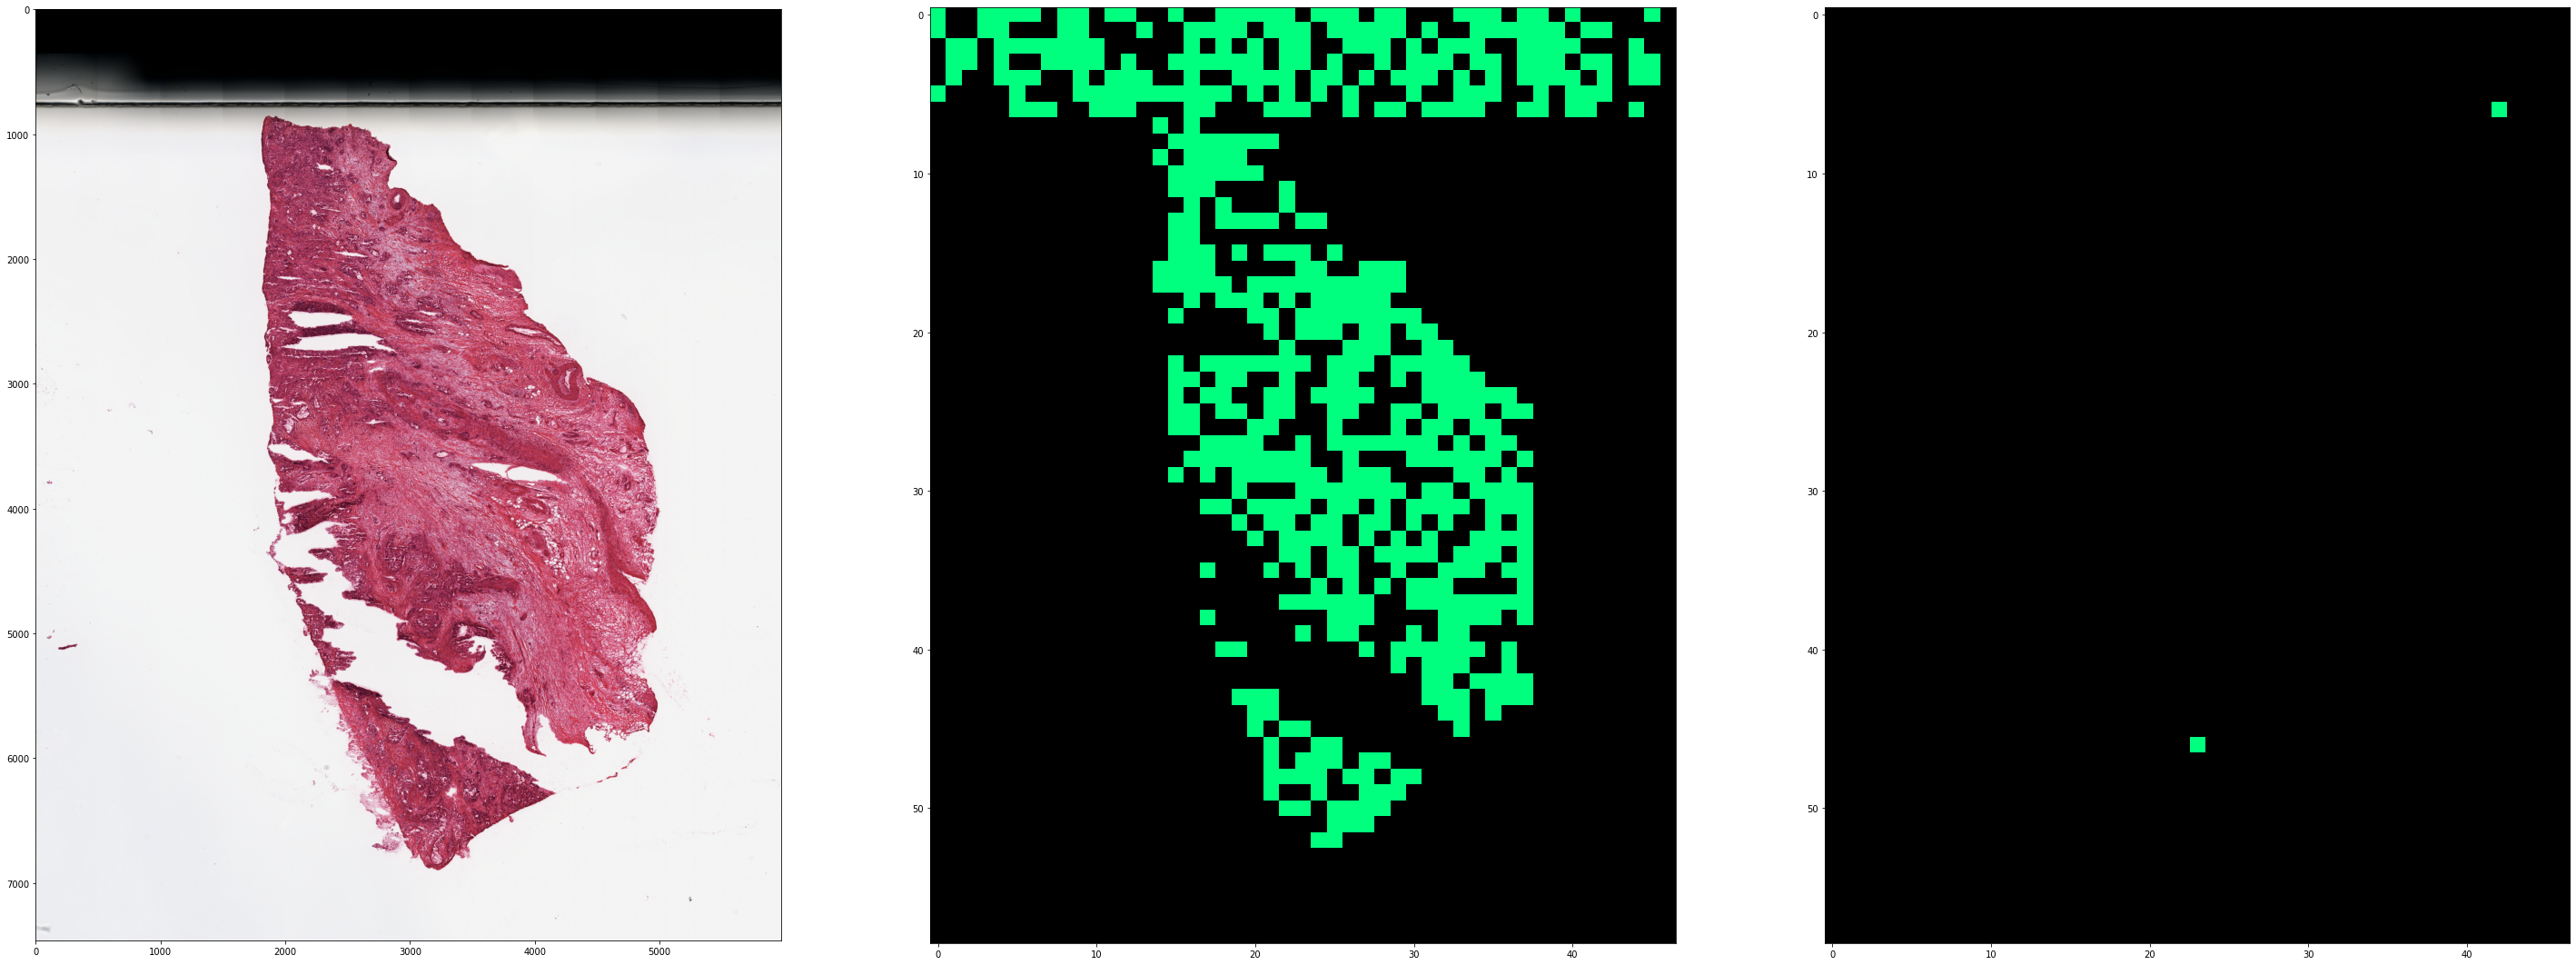

In [49]:
import os
!mkdir data
!mkdir data/mages
valid_image_path_list = os.listdir("/content/test_data")
k=33
test_path='/content/test_data/'+valid_image_path_list[k]
image_depth, image_width, tissue_regions, slide_image_test = test_part_1(test_path ,num_pixels=128,num_level = 1)
src_path="/content/data/"+ valid_image_path_list[k][:-4]
des_path="/content/data/mages/"
!mv $src_path $des_path
ds_test, steps_per_epoch_test = train_part(valid_image_path_list[k],num_level_1=1)
test_predicts = dense.predict(ds_test,steps=steps_per_epoch_test)
all_image_paths_1= gen_image_paths(test_path,1)
test = test_predicts[0:len(all_image_paths_1), :]
img_num = np.zeros(len(all_image_paths_1))
for i in range(len(all_image_paths_1)):
  img_num[i] = int(all_image_paths_1[i].strip('.jpg').split('/')[-1].split('_')[-1])
tumor_list=[]
no_tumor_list=[]
conf_threshold = 0.85
for i in range(len(test)):
  no_tumor_list.append(test[i][0])
  tumor_list.append(test[i][1])
tumor_array = np.zeros((image_depth, image_width))
no_tumor_array = np.zeros((image_depth, image_width))
import numpy as np
tumor_array_test=np.array(tumor_list)
no_tumor_array_test=np.array(no_tumor_list)
for i in range(len(test)):
  y = int(img_num[i] // image_width)
  x = int(np.mod(img_num[i], image_width))
  tumor_array[y, x] = int(tumor_array_test[i] > conf_threshold)
  no_tumor_array[y, x] = int(no_tumor_array_test[i] > conf_threshold)

import matplotlib
cmap = matplotlib.colors.ListedColormap(['black','springgreen'])
cmap1 = matplotlib.colors.ListedColormap(['black','springgreen'])
plt.figure(figsize=(50,20))
plt.subplot(1,3,1)
plt.imshow(slide_image_test)
plt.grid(False)
plt.subplot(1,3,2)               
heatmap=plt.imshow(no_tumor_array, cmap=cmap) 
plt.grid(False)
plt.subplot(1,3,3)               
heatmap1=plt.imshow(tumor_array, cmap=cmap1) 
plt.grid(False)
!rm -r data